Epoch 1/100, Training Loss: 1.1051, Validation Loss: 0.5140
Epoch 2/100, Training Loss: 0.4119, Validation Loss: 0.3467
Epoch 3/100, Training Loss: 0.3126, Validation Loss: 0.2851
Epoch 4/100, Training Loss: 0.2653, Validation Loss: 0.2502
Epoch 5/100, Training Loss: 0.2347, Validation Loss: 0.2273
Epoch 6/100, Training Loss: 0.2125, Validation Loss: 0.2098
Epoch 7/100, Training Loss: 0.1951, Validation Loss: 0.1964
Epoch 8/100, Training Loss: 0.1807, Validation Loss: 0.1853
Epoch 9/100, Training Loss: 0.1685, Validation Loss: 0.1761
Epoch 10/100, Training Loss: 0.1578, Validation Loss: 0.1680
Epoch 11/100, Training Loss: 0.1485, Validation Loss: 0.1610
Epoch 12/100, Training Loss: 0.1401, Validation Loss: 0.1549
Epoch 13/100, Training Loss: 0.1326, Validation Loss: 0.1497
Epoch 14/100, Training Loss: 0.1257, Validation Loss: 0.1447
Epoch 15/100, Training Loss: 0.1194, Validation Loss: 0.1405
Epoch 16/100, Training Loss: 0.1135, Validation Loss: 0.1366
Epoch 17/100, Training Loss: 0.10

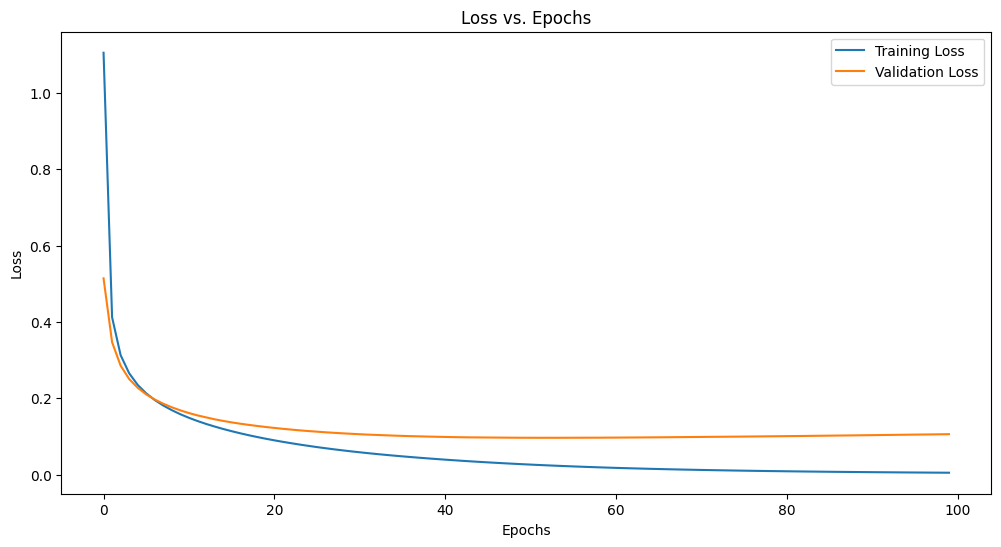

Accuracy on the test set: 97.46%


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Activation Functions
def sigmoid(x, derivative=False):
    if derivative:
        s = sigmoid(x)
        return s * (1 - s)
    return 1 / (1 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        t = tanh(x)
        return 1 - t ** 2
    return np.tanh(x)

def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False, alpha=0.01):
    if derivative:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, x * alpha)

def linear(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    return x

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def get_activation_function(name):
    return {
        'sigmoid': sigmoid,
        'tanh': tanh,
        'relu': relu,
        'leaky_relu': leaky_relu,
        'linear': linear,
        'softmax': softmax  # Only for output layer
    }[name]

# Weight Initialization Functions
def zero_init(in_features, out_features):
    return np.zeros((in_features, out_features))

def random_init(in_features, out_features):
    return np.random.rand(in_features, out_features) * 0.01

def normal_init(in_features, out_features):
    std = np.sqrt(2. / in_features)  
    return np.random.normal(0, std, size=(in_features, out_features))

def get_weight_initialization_function(name):
    return {
        'zero': zero_init,
        'random': random_init,
        'normal': normal_init
    }[name]



# Neural Network Class
class NeuralNetwork:
    def __init__(self, layers, learning_rate, activation_function, weight_init_name, epochs, batch_size):
        self.N = len(layers)
        self.layers = layers
        self.lr = learning_rate
        self.activation = get_activation_function(activation_function)
        self.activation_name = activation_function
        self.weight_init = get_weight_initialization_function(weight_init_name)
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(self.N - 1):
            self.weights.append(self.weight_init(layers[i], layers[i+1]))
            self.biases.append(np.zeros((1, layers[i+1])))
        

    @staticmethod        
    def cross_entropy(y_pred, y_true):
        # To ensure stability and avoid log(0), we use a small value epsilon
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        ce = -np.sum(y_true * np.log(y_pred + 1e-9)) / y_pred.shape[0]
        return ce

    
    def fit(self, X_train, Y_train, X_val, Y_val):
        loss_history = []
        val_loss_history = []
        
        for epoch in range(self.epochs):
            epoch_losses = []  # To store loss of each batch

            # Training
            for i in range(0, X_train.shape[0], self.batch_size):
                end = i + self.batch_size
                batch_x, batch_y = X_train[i:end], Y_train[i:end]
                activations = [batch_x]

                # Forward propagation
                for w, b in zip(self.weights, self.biases):
                    z = np.dot(activations[-1], w) + b
                    if w is not self.weights[-1]:
                        a = self.activation(z)
                    else:
                        a = softmax(z)
                    activations.append(a)

                # Compute the loss for the current batch
                batch_loss = NeuralNetwork.cross_entropy(activations[-1], batch_y)
                epoch_losses.append(batch_loss)

                # Backward propagation
                delta = activations[-1] - batch_y
                for j in range(self.N - 2, -1, -1):
                    dw = np.dot(activations[j].T, delta) / self.batch_size
                    db = np.sum(delta, axis=0, keepdims=True) / self.batch_size
                    if j > 0:
                        delta = np.dot(delta, self.weights[j].T) * self.activation(activations[j], derivative=True)
                    self.weights[j] -= self.lr * dw
                    self.biases[j] -= self.lr * db

            # Calculate average loss for the epoch
            average_epoch_loss = np.mean(epoch_losses)
            loss_history.append(average_epoch_loss)

            # Validation
            val_activations = [X_val]
            for w, b in zip(self.weights, self.biases):
                z = np.dot(val_activations[-1], w) + b
                if w is not self.weights[-1]:
                    a = self.activation(z)
                else:
                    a = softmax(z)
                val_activations.append(a)
            
            val_loss = NeuralNetwork.cross_entropy(val_activations[-1], Y_val)
            val_loss_history.append(val_loss)

            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {average_epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        return loss_history, val_loss_history

        
    def predict(self, X):
        a = X
        for w, b in zip(self.weights, self.biases):
            z = np.dot(a, w) + b
            if w is not self.weights[-1]:
                a = self.activation(z)
            else:
                a = softmax(z)
        return np.argmax(a, axis=1)
    
    def predict_proba(self, X):
        a = X
        for w, b in zip(self.weights, self.biases):
            z = np.dot(a, w) + b
            if w is not self.weights[-1]:
                a = self.activation(z)
            else:
                a = softmax(z)
        return a
    
    def score(self, X, Y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == np.argmax(Y, axis=1))
        return accuracy

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
train_df = pd.read_csv('/Users/abhijaysingh/Documents/College/Semester 5/ML/Assignment 3/mnist_train.csv')
test_df = pd.read_csv('/Users/abhijaysingh/Documents/College/Semester 5/ML/Assignment 3/mnist_test.csv')

# Assuming the first column 'label' is the target and the rest are features
X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values / 255.0
y_test = test_df['label'].values



# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_encoded = onehot_encoder.transform(y_test.reshape(len(y_test), 1))

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42
)

nn = NeuralNetwork(layers=[X_train.shape[1], 256, 128, 64, 32, 10],  # Including the input and output layer sizes
                    learning_rate=0.01,
                    activation_function='relu',
                    weight_init_name='normal',
                    epochs=100,
                    batch_size=128)

# Train the network (assuming fit method is implemented as provided)
train_loss_history, val_loss_history = nn.fit(X_train_split, y_train_split, X_val_split, y_val_split)

# Make predictions (assuming predict method is implemented)
y_pred = nn.predict(X_test)

# Convert one-hot encoded test labels back to class labels for comparison
y_test_labels = np.argmax(y_test_encoded, axis=1)



# Plotting the loss histories
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")